## Preparatory work

In [1]:
# import some necessary libraries

import numpy as np
import pandas as pd # data processing, CSV file I/O
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
sns.set_style('darkgrid')

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) # limiting floats output to 3 decimal points

# ignore warning (from sklearn and seaborn)
import warnings
def ignore(*args, **kwargs):
    pass
warnings.warn = ignore

In [2]:
# import and put the train and test datasets in pandas dataframe

train = pd.read_csv('./data/train.csv', index_col=0)
test = pd.read_csv('./data/test.csv', index_col=0)

In [3]:
# display the first five rows of the train dataset

train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# display the first five rows of the test dataset

test.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Data Processing

### Data Correlation

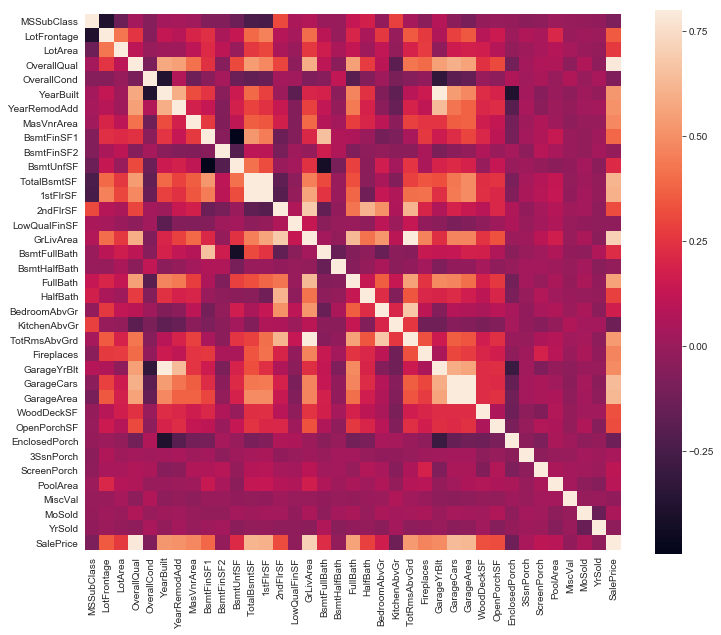

In [5]:
# correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, vmax=.8, square=True)

At first sight, we can notice two white colored squares. The first one refers to 'TotalBsmtSF' and '1stFlrSF' variables, and the second one refers to the 'GarageX' variables.

Actually, this correlation indicate a situation of multicollinearity.

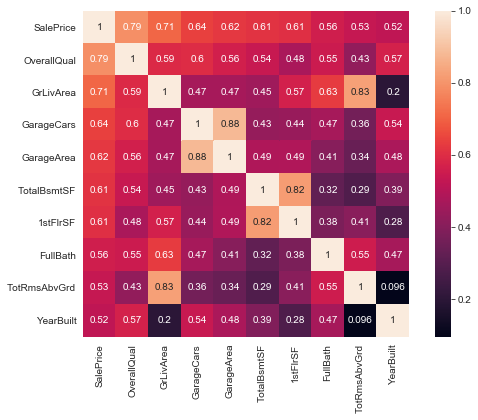

In [6]:
# SalePrice correlation matrix
corrmat = corrmat.nlargest(10, 'SalePrice')
corrmat = corrmat[corrmat.index]
plt.subplots(figsize=(9, 6))
sns.heatmap(corrmat, annot=True, square=True)

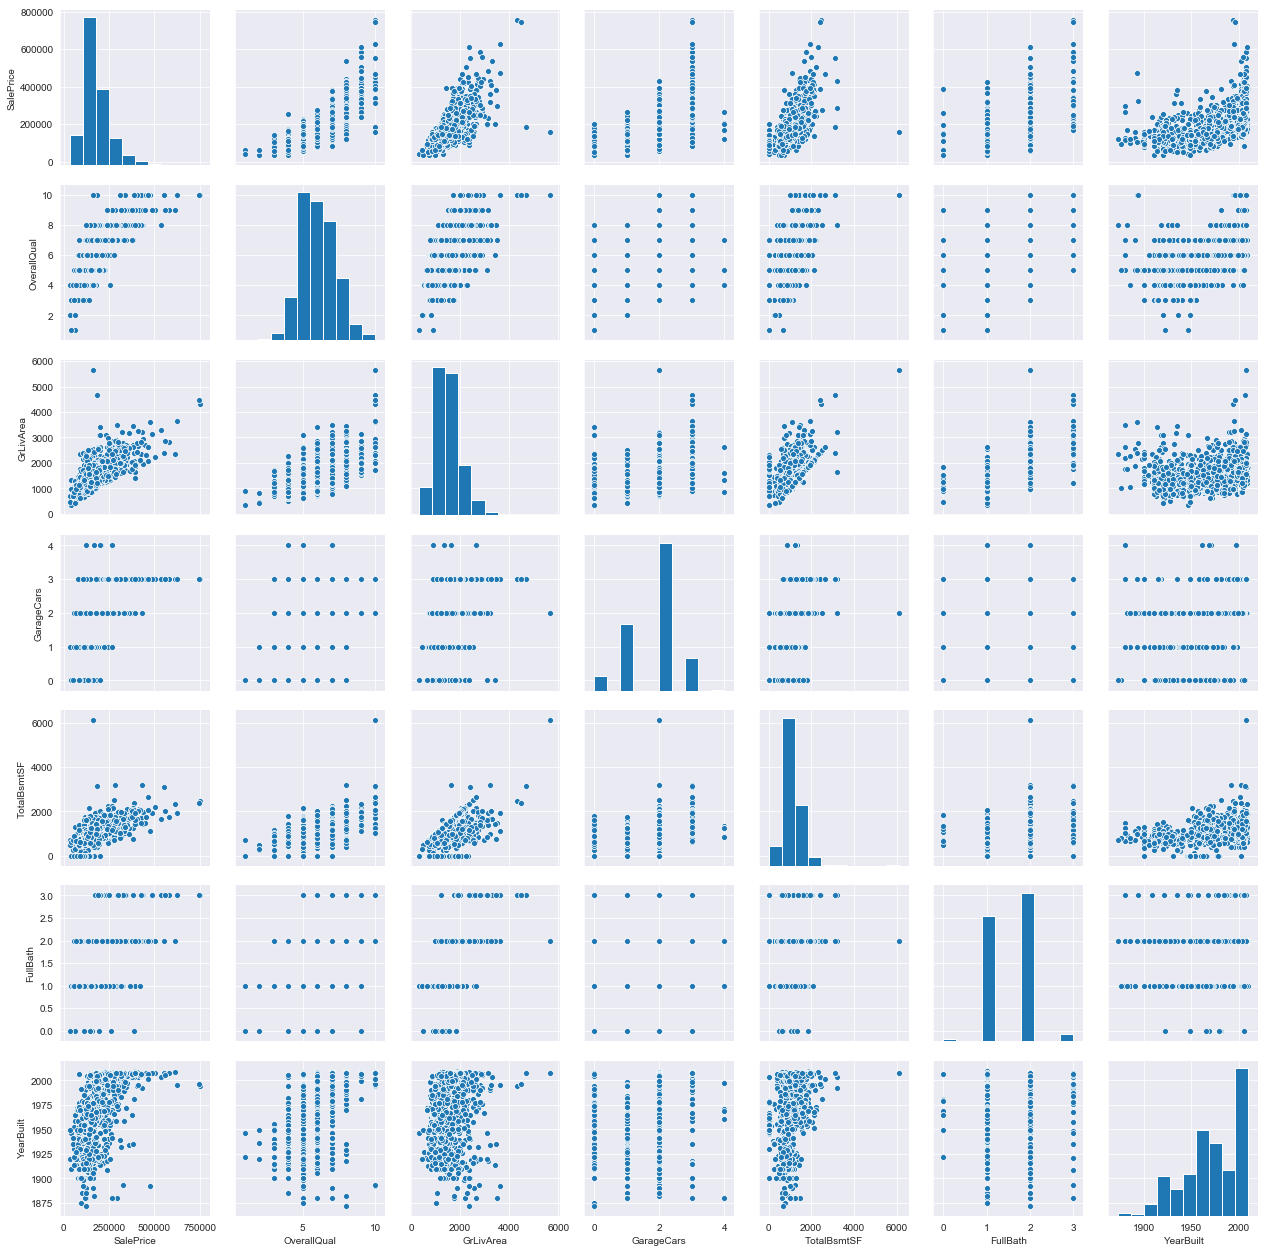

In [7]:
# scatter plot
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols])
plt.show()

### Outliers
Documentation for the Ames Housing Data indicates that there are outliers present in the training data

GrLivArea

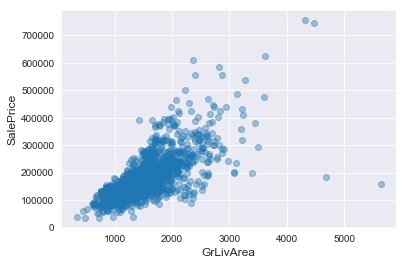

In [8]:
plt.scatter(x=train['GrLivArea'], y=train['SalePrice'], alpha=0.4)
plt.xlabel('GrLivArea', fontsize=12)
plt.ylabel('SalePrice', fontsize=12)
plt.show()

We can see the bottom right two with large GrLivArea that are of a low price. These values are outliers. Therefore, we can delete them.

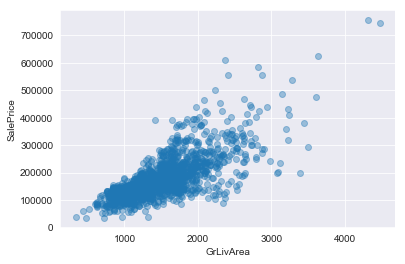

In [9]:
# delete outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# check the graphic
plt.scatter(x=train['GrLivArea'], y=train['SalePrice'], alpha=0.4)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

Now it's a __linear relationship__ between SalePrice and GrLiveArea

What about TotalBsmtSF?

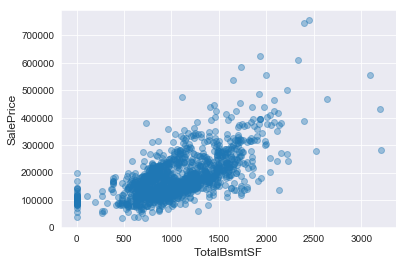

In [10]:
plt.scatter(x=train['TotalBsmtSF'], y=train['SalePrice'], alpha=0.4)
plt.xlabel('TotalBsmtSF', fontsize=12)
plt.ylabel('SalePrice', fontsize=12)
plt.show()

Categorical Features: OverallQual

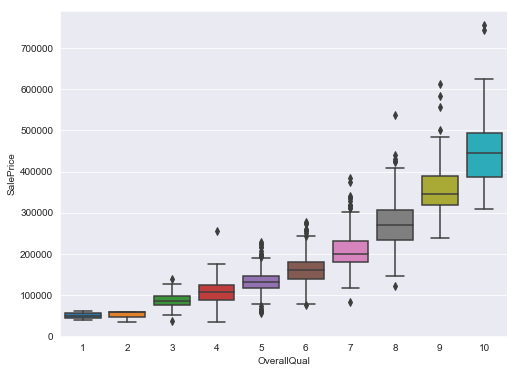

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(x=train['OverallQual'], y=train['SalePrice'])

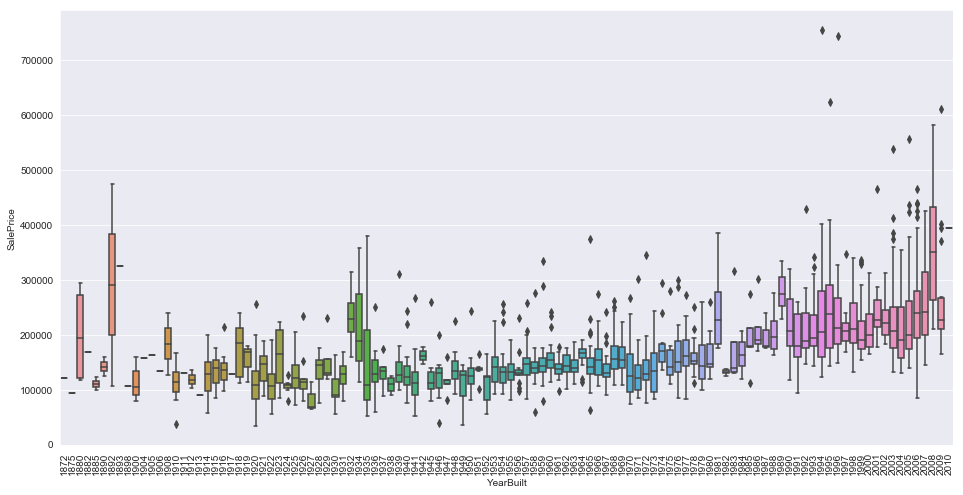

In [12]:
plt.subplots(figsize=(16,8))
plt.xticks(rotation='90')
sns.boxplot(x=train['YearBuilt'], y=train['SalePrice'])

### Target Variable

__SalePrice__ is the variable we need to predict. So we should do some analysis on this variable first

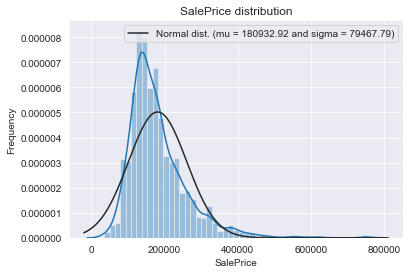

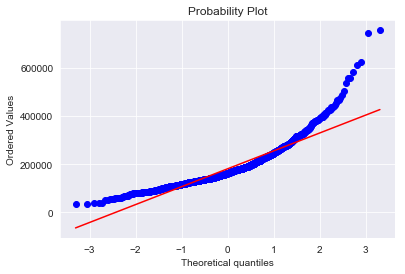

In [13]:
sns.distplot(train['SalePrice'], fit=norm)

# get the fitted parameters used by the function
mu, sigma = norm.fit(train['SalePrice'])

plt.legend(['Normal dist. (mu = {:.2f} and sigma = {:.2f})'.format(mu, sigma)])
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# get QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

The target variable is right skewed. As linear models love normally distributed data, so we need to transform this variable and make it more normally distributed.

#### Box-Cox transformation

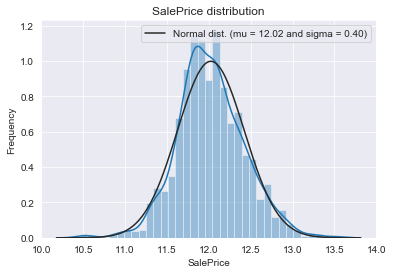

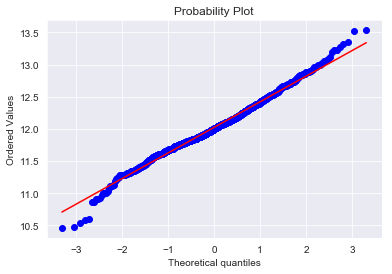

In [14]:
# log1p --> log(1+x)
train['SalePrice'] = np.log1p(train['SalePrice'])

# check the new distribution
sns.distplot(train['SalePrice'], fit=norm)

# get mu and sigma
mu, sigma = norm.fit(train['SalePrice'])

# plot the distribution
plt.legend(['Normal dist. (mu = {:.2f} and sigma = {:.2f})'.format(mu, sigma)])
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# get the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

### Feature Engineering

In [15]:
ntrain = train.shape[0]
ntest = test.shape[0]
y = train.SalePrice.values
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data.shape

(2917, 79)

#### Missing Data

In [16]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head(10)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageYrBlt,5.451
GarageQual,5.451
GarageCond,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

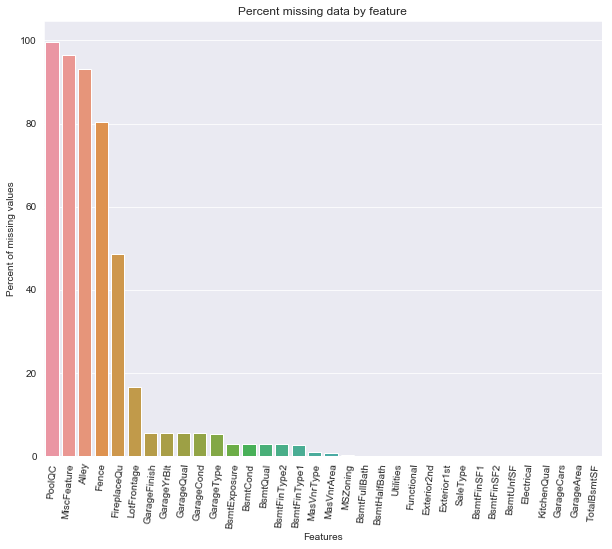

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.xticks(rotation='85')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features')
plt.ylabel('Percent of missing values')
plt.title('Percent missing data by feature')

We input them by proceeding sequentially through features with missing values

__PoolQC__ : data description says NA means "No Pool".

In [18]:
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

__MiscFeature__ : data description says NA means no miscellaneous feature

In [19]:
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

__Alley__ : data description says NA means no alley access

In [20]:
all_data['Alley'] = all_data['Alley'].fillna('None')

__Fence__ : data description says NA means "No Fence"

In [21]:
all_data['Fence'] = all_data['Fence'].fillna('None')

__FireplaceQu__ : data description says NA means "No Fireplace"

In [22]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

__LotFrontage__ : Since the area of each street connected to the house property most likely havva a similar area to other houses in its neighborhood, we can __fill in missing values by the median LotFrontage of the neighborhood.__

In [23]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

__GarageType, GarageFinish, GarageQual and GarageCond__ : Replacing missing data with None

In [24]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

__GarageYrBlt, GarageArea and GarageCars__ : Replacing missing data with 0 (Since No garage = no cars in such garage)

In [25]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

__BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath__ : missing values are likely zero for having no basement

In [26]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

__BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2__ : For all these categorical basement-related features, NA means that there is no basement.

In [27]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

__MasVnrArea and MasVnrType__ : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [28]:
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)

__MSZoning (The general zoning classification)__ : 'RL' is by far the most common value. So we can fill in missing values with 'RL'

In [29]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

__Utilities__ : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA. Since the house with 'NoSewa' is in the training set, __this feature won't help in predictive modeling.__ We can then safely remove it.

In [30]:
all_data = all_data.drop(['Utilities'], axis=1)

__Functional__ : data description says NA means typical

In [31]:
all_data['Functional'] = all_data['Functional'].fillna('Typ')

__Electrical__ : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

In [32]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

__KitchenQual__ : Only one NA value, and same as Electrical, we can set 'TA'.

In [33]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

__Exterior1st and Exterior2nd__ : aAgain Both Exterior1 & 2 have only one missing value. We will just substitute in the most common string

In [34]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

__SaleType__ : Fill in again with most frequent which is 'WD'

In [35]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

__MSSubClass__ : NA most likely means No building class. We can replace missing values with None

In [36]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna('None')

In [37]:
# check remaining missing values if any
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Mssing Ratio' : all_data_na})
missing_data.head()

,Mssing Ratio


Now there's no missing value.

#### More features engeneering

Transforming numerical variables that are really categorical

In [38]:
# MSSubClass --> the building class 
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

# Year and month sold are transformed into categorical features
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

Label Encoding some categorical variables that may contain information in their ordering set

In [39]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 
        'LandSlope','LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir',
        'MSSubClass', 'OverallCond', 'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features
for c in cols:
    le = LabelEncoder() 
    le.fit(all_data[c]) 
    all_data[c] = le.transform(all_data[c])

__Adding one more important feature__

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [40]:
# adding total sqfootage feature
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

__Skewed features__

In [41]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

# check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' : skewed_feats})
skewness.head()

,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372


__Box-Cox Transformation of (highly) skewed features__

We use the scipy.special function boxcox1p which computes the Box-Cox transformation of __1 + x__

Note that setting __lambda = 0__ is equivalent to log1p used above for __SalePrice__

While skew > 0, we set lambda = 0, and if skew < 0, we set lambda > 1

In [42]:
PoSkewness = skewness[skewness['Skew'] > 1].index
NeSkewness = skewness[skewness['Skew'] < -1].index

from scipy.special import boxcox1p
for feature in PoSkewness:
    all_data[feature] = boxcox1p(all_data[feature], 0.15)
for feature in NeSkewness:
    all_data[feature] = boxcox1p(all_data[feature], 10)
skewness['NewSkew'] = all_data[numeric_feats].apply(lambda x: stats.skew(x.dropna()))
skewness.head()

,Skew,NewSkew
MiscVal,21.940,5.595
PoolArea,17.689,15.760
LotArea,13.109,0.178
LowQualFinSF,12.085,8.741
3SsnPorch,11.372,8.922


__One Hot Encoding__ : get dummy categorical features

In [43]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 220)

In [44]:
train = all_data[:ntrain]
test = all_data[ntrain:]

## Modelling

In [45]:
# import libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

### Lasso

In [46]:
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(RobustScaler(), Lasso())
param_grid= {'lasso__alpha': [0.0004, 0.0006, 0.0008]}
X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=0)
grid = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring='neg_mean_squared_error', iid=True, cv=5)

In [47]:
grid.fit(X_train, y_train)
grid.best_estimator_

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0006, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [48]:
print('train score: {:.4f}\ntest score:{:.4f}'.format(np.sqrt(-grid.score(X_train, y_train)), np.sqrt(-grid.score(X_test, y_test))))

train score: 0.1013
test score:0.1027


In [52]:
# expm1 --> exp(x)-1
pred = np.expm1(grid.predict(test))
pred

array([120843.59060301, 164753.05719258, 183376.76835514, ...,
       169362.64208725, 117957.79707325, 229773.95095559])

### Elastic Net

In [53]:
pipe = make_pipeline(RobustScaler(), ElasticNet())
param_grid= {'elasticnet__alpha': [0.001, 0.0012, 0.0014]}
X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=0)
grid = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring='neg_mean_squared_error', iid=True, cv=5)

In [54]:
grid.fit(X_train, y_train)
grid.best_estimator_

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnet', ElasticNet(alpha=0.0012, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])

In [55]:
print('train score: {:.4f}\ntest score:{:.4f}'.format(np.sqrt(-grid.score(X_train, y_train)), np.sqrt(-grid.score(X_test, y_test))))

train score: 0.1016
test score:0.1030


In [56]:
# expm1 --> exp(x)-1
pred = np.expm1(grid.predict(test))
pred

array([120468.21253403, 164795.66616858, 183343.84391492, ...,
       169520.82768704, 117960.47562506, 229624.41664595])

### Random Forest

In [72]:
pipe = make_pipeline(RandomForestRegressor(oob_score=True, random_state=8))
param_grid= {'randomforestregressor__n_estimators': [300, 400, 500]}
X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=0)
grid = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring='neg_mean_squared_error', iid=True, cv=5)

In [73]:
grid.fit(X_train, y_train)
grid.best_estimator_

Pipeline(memory=None,
     steps=[('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=True, random_state=8, verbose=0, warm_start=False))])

In [74]:
print('train score: {:.4f}\ntest score:{:.4f}'.format(np.sqrt(-grid.score(X_train, y_train)), np.sqrt(-grid.score(X_test, y_test))))

train score: 0.0523
test score:0.1237


### Xgboost

In [45]:
import xgboost as xgb
# be continued

ModuleNotFoundError: No module named 'xgboost'

__Submission__

In [57]:
sub = pd.DataFrame()
sub['Id'] = pd.read_csv('./data/test.csv').Id
sub['SalePrice'] = pred
sub.to_csv('./data/submission.csv',index=False)